# Text Classifier

# 1 - Packages

Let's first import all the packages that I'll be using during this project.

* numpy is the main package for scientific computing with Python.
* pandas is a library for data manipulation and analysis.
* train_test_split is used to split our training data into training, dev datasets.
* accuracy_score, classification_report are to test the performance of the models.
* Tokenizer allows to vectorize a text corpus, by turning each text into a vector.
* pad_sequences transforms a list of num_samples sequences into a 2D Numpy array.
* keras.layers contains the layers we'll use to create our RNN.
* stopwords are used to remove the useless words from our dataset.
* Mode, Sequential will contain all the layers we'll use to get our output.
* WordCloud is used to visualize the words in the dataset.

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional, GlobalMaxPool1D, Conv1D, MaxPooling1D
from keras.models import Model, Sequential
from nltk.corpus import stopwords
from textblob import Word
from wordcloud import WordCloud

Using TensorFlow backend.


# 2 - Dataset

* I am using the dataset provided by AkaikeTech as an assignment.
* train_labels is a modified version of the train_label dataset. I altered it so that I can confortably use it in this model.
* embedding_file is the word embedding matrix which contains the properties and relations of all the words and I am using 50d feature matrix for this assignment.

In [2]:
train = pd.read_csv('../input/akaike/train_data.csv')
train_labels = pd.read_csv('../input/akaike/train_labels.csv').drop(columns = ['Unnamed: 0'])
test = pd.read_csv('../input/akaike/test_data.csv')
sample_submission = pd.read_csv('../input/akaike/sample_submission.csv')
embedding_file = '../input/glove6b50d/glove.6B.50d.txt'

In [3]:
train.head()

,text,id
0,"Keep your gloves, hats, coats and jackets toge...",122885
1,The Home Dynamix Serendipity Ivory 5 ft. 2 in....,188958
2,The Bosch 18-Volt lithium-ion line of Cordless...,146065
3,Restore your Porter-Cable sander or polisher t...,165138
4,The SPIKECUBE Surge Suppressor from Tripp Lite...,185565


The output below are the output classes and we are going to classify our text dataset in these labels.

In [ ]:
print(sample_submission.columns[1:])

# 3 - Data Pre-processing

Now we have our dataset but it isn't ready yet for the model training as there are a lot we can do with our data to make the training process smooth.

'id' is the column which is used to map a text to it's labels but if we modify the indices according to these 'id's then we can ditch this column which will make things easy for us as we move further.

In [5]:
train = train.sort_values(by = ['id']).reset_index(drop=True).drop(columns = ['id'])
train_labels = train_labels.sort_values(by = ['id']).reset_index(drop=True).drop(columns = ['id'])
print('There are {} words'.format(train['text'].apply(lambda x: len(x.split(' '))).sum()))

There are 5554696 words


In [6]:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 900 # max number of words in a comment to use

There are a bunch of text preprocessing techniques which can improve the performance of a text classifier dramatically. Some of these techniques are - 

## 1 - Lower case

The first pre-processing step which we will do is transform our text into lower case. This avoids having multiple copies of the same words. For example, while calculating the word count, ‘Analytics’ and ‘analytics’ will be taken as different words.

## 2 - Removing Punctuation

The next step is to remove punctuation, as it doesn’t add any extra information while treating text data. Therefore removing all instances of it will help us reduce the size of the training data.

## 3 - Removal of Stop Words

As we discussed earlier, stop words (or commonly occurring words) should be removed from the text data. For this purpose, we can either create a list of stopwords ourselves or we can use predefined libraries.

## 4 - Lemmatization

Lemmatization is a more effective option than stemming because it converts the word into its root word, rather than just stripping the suffices. It makes use of the vocabulary and does a morphological analysis to obtain the root word. Therefore, we usually prefer using lemmatization over stemming.

## 5 - Remove Integers

Removing the integers will help us because our dataset doesn't depend on them and by removing them we can reduce the number of low frequency words which will help in training process

In [7]:
def preprocess(df):
    df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split())) # lower case

    df['text'] = df['text'].str.replace('[^\w\s]',' ') # Removing Punctuation

    stop = stopwords.words('english')
    df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop)) # Removal of Stop Words

    df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) # Lemmatization

    df['text'] = df['text'].str.replace('\d+', '') # Removing Digits
    return df

Our dataset has around 130k unique words and most of them never repeated even once in the entire dataset and they can't help our model in learning so here I removed all of them except the ones which occured more than 5 times.

In [8]:
train = preprocess(train)
freq_words = pd.Series(' '.join(train['text']).split()).value_counts()[:20000]
freq_words = list(freq_words.index)
train['text'] = train['text'].apply(lambda x: " ".join(x for x in x.split() if x in freq_words))

* We created an object of Tokenizer class with max numbers = 20000 and then we trained it on X_raw dataset.
* We then turned the list of texts into sequences.
* We then padded our dataset so that every sequence is about the same size.
* We then splitted the features, targets into training, dev sets with 1/5 ratio.

In [9]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(train['text']))
X = tokenizer.texts_to_sequences(train['text'])
X = pad_sequences(X, maxlen)
X_train, X_dev, Y_train, Y_dev = train_test_split(X, train_labels, test_size = 0.2, random_state = 42)
print('Shape of training data is: {}'.format(X_train.shape))
print('Shape of training labels is: {}'.format(Y_train.shape))
print('Shape of dev data is: {}'.format(X_dev.shape))
print('Shape of dev labels is: {}'.format(Y_dev.shape))

Shape of training data is: (33255, 900)
Shape of training labels is: (33255, 15)
Shape of dev data is: (8314, 900)
Shape of dev labels is: (8314, 15)


Here, in the following image the words appearing are the most frequent words in our dataset and the bigger ones are more frequent than others.

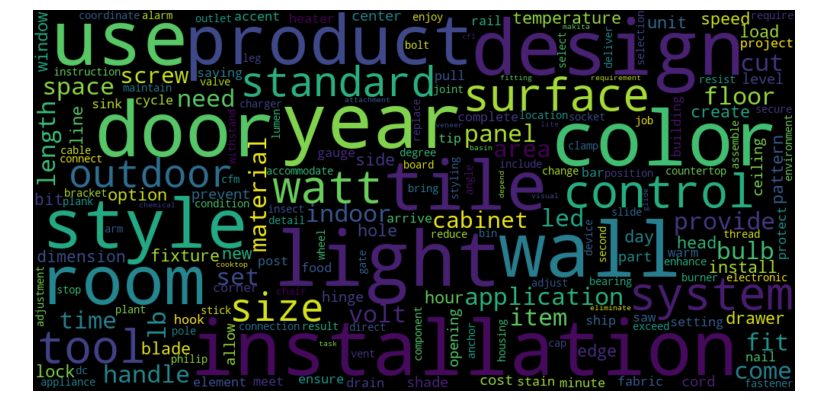

In [10]:
words = ' '.join(list(tokenizer.word_index))
wordcloud = WordCloud(width=1000, height=500, random_state=42, max_font_size=100).generate(words)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [11]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embedding_file))
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


(0.020940498, 0.6441043)

Embedding matrix contains the properties of each word in our dataset and it is the 'weights' we will be refining during the training process.

In [ ]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words + 1, embed_size))
for word, i in word_index.items():
    if i >= max_features : 
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

# 4 - Training 

In this assignment I am gonna use two NN types for text classification to see which works better.

# Recurrent Neural Network (RNN) :

A recurrent neural network (RNN) is a class of artificial neural network where connections between nodes form a directed graph along a sequence. This allows it to exhibit dynamic temporal behavior for a time sequence.

Using the knowledge from an external embedding can enhance the precision of your RNN because it integrates new information (lexical and semantic) about the words, an information that has been trained and distilled on a very large corpus of data.The pre-trained embedding we’ll be using is GloVe.

In [13]:
def rnn_model():
    inp = Input(shape=(maxlen,))
    x = Embedding(embedding_matrix.shape[0], embed_size, weights=[embedding_matrix])(inp)
    x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(15, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
rnn_model = rnn_model()
rnn_model.fit(X_train, Y_train, batch_size=32, epochs=2, validation_split=0.1)

Train on 29929 samples, validate on 3326 samples
Epoch 1/2
29929/29929 [==============================] - 1582s 53ms/step - loss: 3.5337 - acc: 0.3449 - val_loss: 2.8223 - val_acc: 0.4558
Epoch 2/2
29929/29929 [==============================] - 1588s 53ms/step - loss: 2.6278 - acc: 0.5009 - val_loss: 2.3954 - val_acc: 0.5625


# Convolutional Neural Network (CNN) :

CNN is a class of deep, feed-forward artificial neural networks ( where connections between nodes do not form a cycle) & use a variation of multilayer perceptrons designed to require minimal preprocessing. These are inspired by animal visual cortex.

CNNs are generally used in computer vision, however they’ve recently been applied to various NLP tasks and the results were promising So I am gonna give them a try.

In [14]:
def conv_model():
    model_conv = Sequential()
    model_conv.add(Embedding(embedding_matrix.shape[0], embed_size, weights=[embedding_matrix], input_length=maxlen))
    model_conv.add(Dropout(0.2))
    model_conv.add(Conv1D(64, 5, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=4))
    model_conv.add(LSTM(100))
    model_conv.add(Dense(15, activation='sigmoid'))
    model_conv.compile(loss='categorical_crossentropy', optimizer='adam',    metrics=['accuracy'])
    return model_conv
conv_model = conv_model()
conv_model.fit(X_train, Y_train, batch_size=32, epochs=2, validation_split=0.1)

Train on 29929 samples, validate on 3326 samples
Epoch 1/2
29929/29929 [==============================] - 229s 8ms/step - loss: 3.4487 - acc: 0.3630 - val_loss: 2.9157 - val_acc: 0.4296
Epoch 2/2
29929/29929 [==============================] - 235s 8ms/step - loss: 2.6415 - acc: 0.4899 - val_loss: 2.5271 - val_acc: 0.5108


We can't use the raw predicted values because that will give us a wrong estimate of the accuracy of our model so here I am converting it into a more finished version of the predictions.

In [15]:
def one_hot(arr):
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if arr[i][j] >= 0.25:
                arr[i][j] = 1
            else:
                arr[i][j] = 0
    return arr

# 5 - Testing

I have trained two models for text prediction so now let's test them on test dataset to see how it performs on unseen datasets.

In [16]:
Y_rnn_pred = one_hot(conv_model.predict(X_dev))
Y_conv_pred = one_hot(rnn_model.predict(X_dev))

In [18]:
print('accuracy of RNN model is  %s' % accuracy_score(Y_dev.values, Y_rnn_pred))
print('accuracy of CONV model is  %s' % accuracy_score(Y_dev.values, Y_conv_pred))

accuracy of RNN model is  0.4208563868174164
accuracy of CONV model is  0.46187154197738756


In [19]:
print('classifications report of RNN model - ')
print(classification_report(Y_dev.values, Y_rnn_pred, target_names=sample_submission.columns[1:]))

classifications report of RNN model - 
                          precision    recall  f1-score   support

          Indoor/Outdoor       0.65      0.81      0.72      1885
Commercial / Residential       0.82      0.76      0.78      1357
   ENERGY STAR Certified       0.83      0.85      0.84      1329
       Hardware Included       0.75      0.51      0.61      1121
        Package Quantity       0.78      0.76      0.77       966
   Flooring Product Type       0.87      0.94      0.90       884
                   Color       0.69      0.36      0.48       917
      Tools Product Type       0.81      0.91      0.86       922
                Included       0.78      0.51      0.61       891
         Voltage (volts)       0.68      0.75      0.71       871
       Assembly Required       0.87      0.64      0.74       876
                Features       0.83      0.87      0.85       796
         Wattage (watts)       0.56      0.82      0.66       773
                  Finish       0.71 

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [20]:
print('classifications report of CONV model - ')
print(classification_report(Y_dev.values, Y_conv_pred, target_names=sample_submission.columns[1:]))

classifications report of CONV model - 
                          precision    recall  f1-score   support

          Indoor/Outdoor       0.66      0.89      0.76      1885
Commercial / Residential       0.82      0.79      0.81      1357
   ENERGY STAR Certified       0.78      0.89      0.83      1329
       Hardware Included       0.71      0.66      0.68      1121
        Package Quantity       0.86      0.73      0.79       966
   Flooring Product Type       0.90      0.93      0.91       884
                   Color       0.71      0.47      0.57       917
      Tools Product Type       0.90      0.91      0.90       922
                Included       0.78      0.59      0.67       891
         Voltage (volts)       0.74      0.80      0.77       871
       Assembly Required       0.93      0.62      0.74       876
                Features       0.85      0.86      0.86       796
         Wattage (watts)       0.58      0.85      0.69       773
                  Finish       0.68

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Now that all is done, we can predict the labels for the 'test' dataset and then export it in a .csv file

In [21]:
test = preprocess(test)
ids = test['id']
test = test.drop(columns = ['id'])
test = tokenizer.texts_to_sequences(test['text'])
test = pad_sequences(test, maxlen)

In [22]:
predictions = one_hot(conv_model.predict(test))

In [23]:
predictions = pd.DataFrame(predictions, columns = sample_submission.columns[1:])
predictions['id'] = ids
cols = predictions.columns.tolist()
cols = cols[-1:] + cols[:-1]
predictions = predictions[cols]

In [24]:
predictions.to_csv('preds.csv')

# Conclusion - 
* Using the above mentioned pre-processing technqiues can improve the performance of a text classification dramatically.
* CNN can be used for tasks other than computer vision.
* Never - ever judge your model's performance solely based on cross validation errors in classification tasks.